In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
def getMiscDict(path):
    dirList = path.split('\\')
    syncType = dirList[len(dirList) - 7]
    memoryStorage = dirList[len(dirList) - 6]
    baseline = dirList[len(dirList) -5]
    testSpreadsheet = dirList[len(dirList) - 4]
    run = int(dirList[len(dirList) - 3].split('-')[1])
    rows = int(dirList[len(dirList) - 2].split('-')[1])
    return {'Sync/Async':syncType, 'Memory Storage':memoryStorage, 'Baseline':baseline,
            'Test Spreadsheet':testSpreadsheet, 'Run':run, 'Rows':rows}

def getMetrics(path):
    """
    Takes in a path string to a .stat file and returns a Pandas DataFrame of the file's contents
    """
    reportsFile = open(path, 'r')
    dataDict = {}
    dataDict = getMiscDict(path)
    for line in reportsFile:
        if ': ' in line:
            metric, value = line.split(": ")
            if metric not in dataDict:
                dataDict[metric] = []
            try:
                dataDict[metric].append(int(value))
            except ValueError:
                dataDict[metric].append(float(value))
            except:
                dataDict[metric].append(value)
    reportsFile.close
    return pd.DataFrame(dataDict)


def getAllMetrics(basePath, miscDict={'sync type':'', 'mem type':'', 'impl':'', 'test':'', 'run':0}):
    """
    Takes in a file path and searches all of its subdirectories for .stat files and returns all of
    their contents in a Pandas DataFrame
    """
    data = pd.DataFrame()
    for file in os.listdir(basePath):
        filePath = os.path.join(basePath, file)
        if os.path.isdir(filePath):
            data = data.append(getAllMetrics(filePath))
        elif file == "core.stat":
            data = data.append(getMetrics(filePath))
    
    return data


def plotAll(data, sheets=['Rate', 'RunningTotalFast', 'RunningTotalSlow'], syncMethod=['async', 'sync']):
    plt.figure()
    #print(plt.rcParams.keys())
    plt.rcParams.update({'font.size': 15, 'figure.figsize': (12,8), 'lines.linewidth':3, 'axes.grid':True})
    for sheet in sheets:
        for sync in syncMethod:
            dataSlice = data.loc[sheet, sync]
            dataSlice = pd.pivot_table(dataSlice, index='Rows', columns=dataSlice.index)['Total time to update cells (ms)']
            plot = dataSlice.plot.line()
            if sync=='sync':
                plot.set_title('Number of Rows vs Time to Update Spreadsheet (' + sheet + ', ' + sync + ')')
            elif sync=='async':
                plot.set_title('Number of Rows vs Time to Return Control to User (' + sheet + ', ' + sync + ')')
            plot.set_ylabel('Total Time in ms')
            #plt.legend(title='Memory Storage, Implementation')

,Sync/Async,Memory Storage,Baseline,Test Spreadsheet,Run,Rows,Total test time (ms),Number of cells to update,Number of cells updated,Total time to update cells (ms),Total time after the update (ms),Total time of getting dependents (ms),Total time of adding the batch (ms),Total time of refreshing the cache (ms),Area under curve
0,async,DB,Async,RunningTotalSlow,1,10000,300242,10001,10001,46,22014,0,238218,0,1.138713e+08
0,async,DB,Async,RunningTotalSlow,1,15000,1221487,15001,15001,35,33706,0,1127731,0,2.115482e+08
0,async,DB,Async,RunningTotalSlow,1,20000,1439536,20001,20001,37,59367,0,1295672,0,4.347321e+08
0,async,DB,Async,RunningTotalSlow,1,25000,2498934,25001,25001,35,100767,0,2282111,0,8.709743e+08
0,async,DB,Async,RunningTotalSlow,1,5000,93607,5001,5001,43,7970,0,64540,0,3.072790e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,sync,DB,PGImpl,RunningTotalSlow,3,10000,73535,10001,0,23362,6,129,5042,0,4.673600e+08
0,sync,DB,PGImpl,RunningTotalSlow,3,15000,111960,15001,0,38687,9,285,7187,0,1.160880e+09
0,sync,DB,PGImpl,RunningTotalSlow,3,20000,167299,20001,0,72975,14,288,9893,0,2.919560e+09
0,sync,DB,PGImpl,RunningTotalSlow,3,25000,232317,25001,0,111984,17,461,11006,0,5.600050e+09


<Figure size 864x576 with 0 Axes>

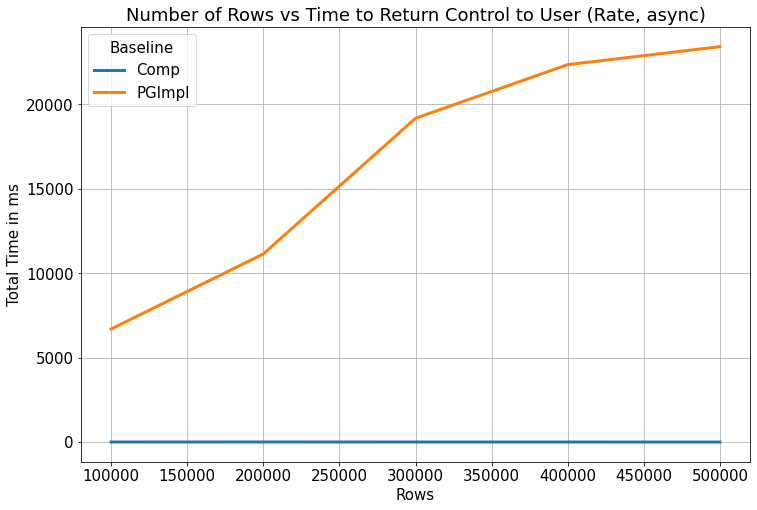

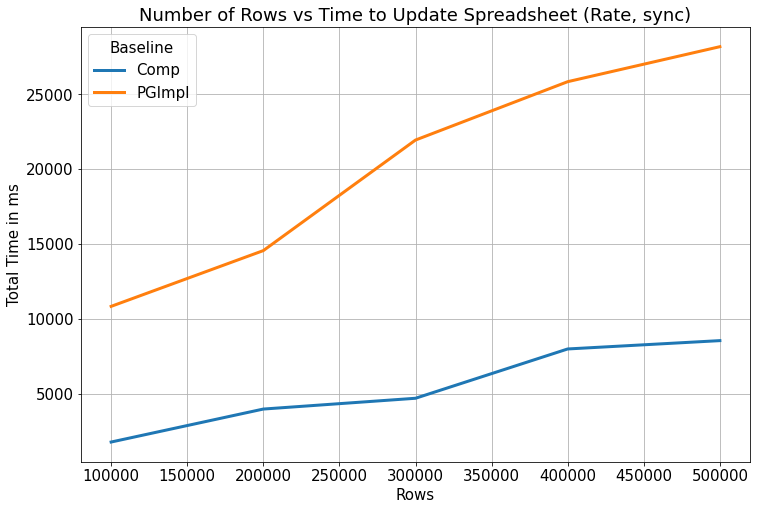

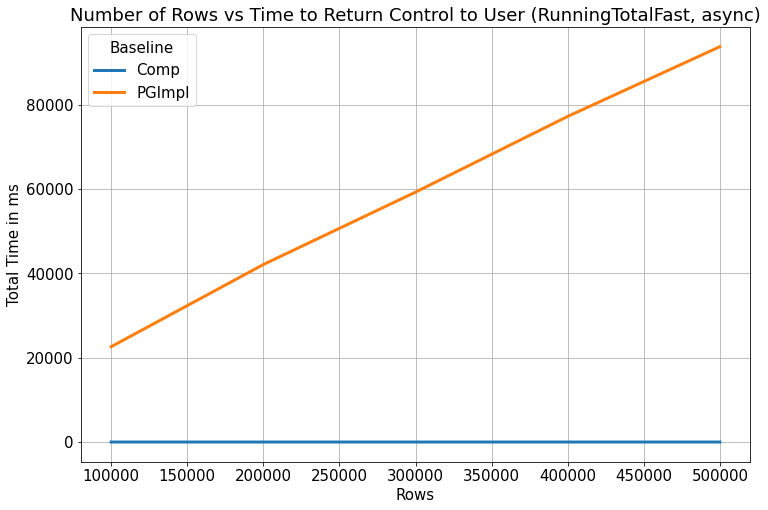

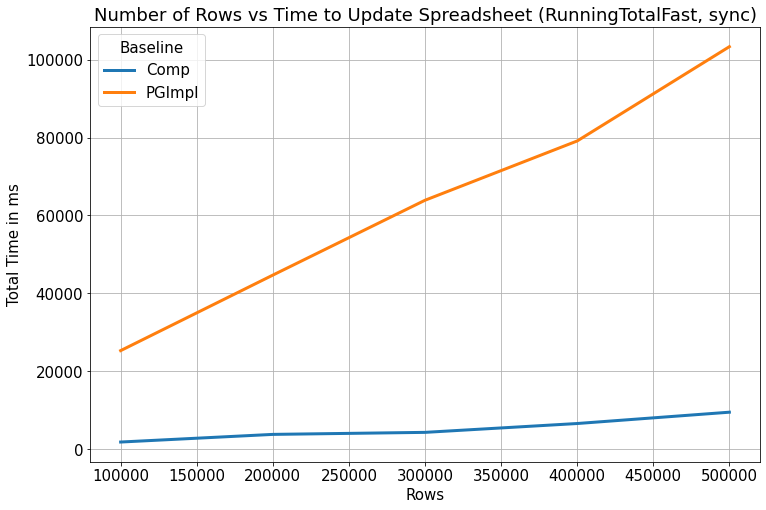

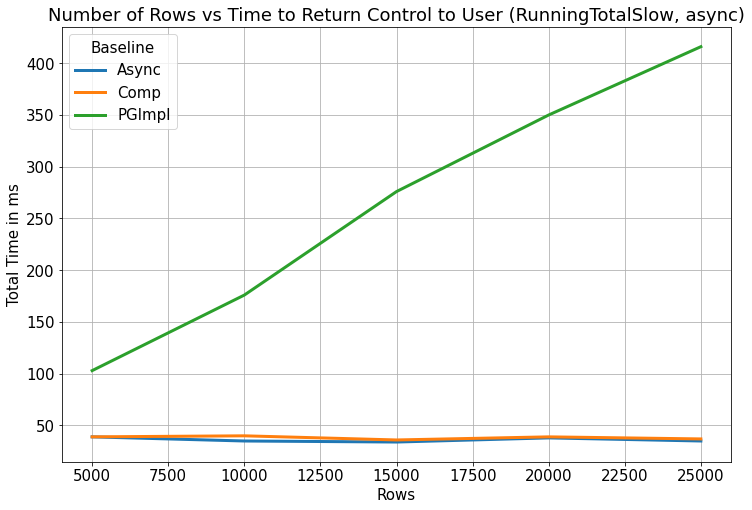

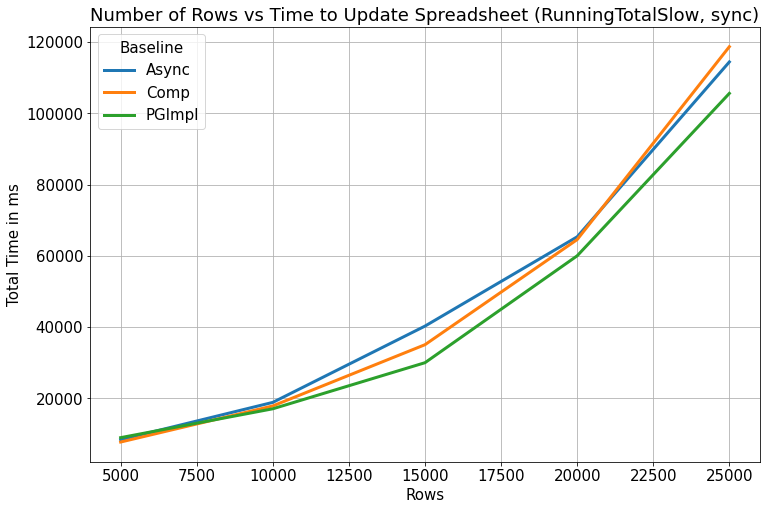

In [4]:
# Formua Compression Test path (CHANGE)
formulaCompressionTestHome = "C:\\Users\\jonat\\Documents\\Dataspread\\FormulaCompressionTest"
testPath = formulaCompressionTestHome + "\\Chris\\FormulaCompressionTesting\\testing\\reports"

pd.set_option('max_rows', 90)
testData = getAllMetrics(testPath)
display(testData)
testData = testData.groupby(['Test Spreadsheet', 'Sync/Async', 'Baseline', 'Rows']).median()
testData = testData.reset_index(level='Rows')
plotAll(testData)